# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database

In [1]:
import numpy as np
import pandas as pd

from asl_data import AslDb
pd.options.display.float_format = '{:0.2f}'.format
from warnings import filterwarnings;filterwarnings('ignore')
import utils
asl = AslDb() # initializes the database

In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from importlib import reload
#%load_ext autoreload
#%autoreload 2

import timeit

##### Test 1 : Feature creation 

In [3]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
grnd=dict()
grnd['lx']=('left','x')
grnd['ly']=('left','y')
grnd['rx']=('right','x')
grnd['ry']=('right','y')
#collect the features in a list
features_ground=features_list('grnd')
for k,v in grnd.items():
    asl.df['grnd-'+k]=asl.df[v[0]+'-'+v[1]] - asl.df['nose-'+v[1]]
    # test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-lx  grnd-ly  grnd-rx  grnd-ry  
video frame                                      
98    0          -12      119        9      113  
      1          -12      119        9      113  
      2          -12      119        9      113  
      3          -12      119        9      113  
      4          -12      119        9      113

To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

##### Test 2 : Standard deviation by speaker

In [8]:
from asl_utils import test_std_tryit
df_std = asl.df.groupby('speaker').std()
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-lx,grnd-ly,grnd-rx
speaker,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,15.080360,36.572749,20.269032
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,17.328941,27.117393,16.764706
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,15.050938,29.320655,16.191324


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
   
- polar coordinates
   
- delta difference
   
- custom features
   

##### Standard features

In [17]:
def define_features(asl):
    #dimensions
    hand=['right','left']
    side=['r','l']
    cartesian = ['x','y']
    polar = ['r','theta']

    #rename the raw data for consistency
    raw_names={h+'-'+c:'raw-'+h[0]+c for h in hand for c in cartesian}
    asl.df=asl.df.rename(columns=raw_names)

    cartesian_features=['grnd','norm','delta']
    cartesian_features={k:[k+'-'+h[0]+c for h in hand for c in cartesian] for k in cartesian_features}

    polar_features={'polar':['polar'+'-'+s+c for s in side for c in polar]}
    return cartesian_features,polar_features

cartesian_features,polar_features = define_features(asl)

In [18]:
def compute_features(asl,cartesian_features,polar_features):
    for f in cartesian_features['grnd']:
        asl.df[f]=asl.df['raw'+f[-3:]] - asl.df['nose-'+f[-1:]]

    df_means = asl.df.groupby('speaker').mean()
    df_std = asl.df.groupby('speaker').std()

    for f in cartesian_features['norm']:
        ref='raw'+f[-3:]
        asl.df[f]=(asl.df[ref]-asl.df['speaker'].map(df_means[ref]))/asl.df['speaker'].map(df_std[ref])

    for f in cartesian_features['delta']:
        ref='grnd'+f[-3:]
        asl.df[f]=(asl.df[ref].diff()).fillna(0)

    ref='grnd'
    asl.df['polar-rtheta']=(np.arctan2(asl.df[ref+'-rx'],asl.df[ref+'-ry']))
    asl.df['polar-ltheta']=(np.arctan2(asl.df[ref+'-lx'],asl.df[ref+'-ly']))
    asl.df['polar-rr']=np.sqrt(asl.df[ref+'-rx']**2+asl.df[ref+'-ry']**2)
    asl.df['polar-lr']=np.sqrt(asl.df[ref+'-lx']**2+asl.df[ref+'-ly']**2)
    return asl

asl=compute_features(asl,cartesian_features,polar_features)

##### Data quality

In [1]:
import utils
asl,features,training,samples,words_info,handedness=utils.init()
words=words_info.index.tolist()

I started out with the following assumptions.

** Assumption:** *Words with more samples/occurences will yield more robust results in the modeling terms of signal vs noise.* 

==> Let's use words with a high sample count.

**Assumption:** *OTOH, words with more samples will be more likely include samples from several different persons, so would be more *exposed* to noise. * 

==> Normalized data will be better.

**Assumption:** *Focusing on more frequency words will have the highest impact on prediction results. * 

==> there might be an easy way to 'game the system' here by overly focusing on words with high prior probabilities, but I will not explore that option.

**Assumption:** *At least five data points are required to make a valid sample (from Thad in lectures). *

==> constrain our test set on having 5> data points.

However, after starting working on the full set of words, inspecting the individual time series, I noticed that **many samples seemed to contain two versions: one with a flat signal for one of the hands**.

In [2]:
words_info.sort_values(by='count',ascending=False).head(10)

,count,min,avg,max,range,spread,single,double
word,,,,,,,,
JOHN,113,5,10.52,27,22,2.09,67,46
IX,52,3,10.06,28,25,2.49,34,18
MARY,37,8,13.95,20,12,0.86,21,16
WHAT,26,5,11.35,21,16,1.41,4,22
WHO,25,3,11.04,17,14,1.27,19,6
BOOK,18,6,9.56,17,11,1.15,1,17
CAN,17,3,7.88,16,13,1.65,0,17
BUY,16,5,6.75,10,5,0.74,0,16
CAR,16,7,9.25,17,10,1.08,0,16


We can see that ***JOHN***, the most frequent word, has **67 samples with single-handed data** only, and **46 samples with double-handed** data. Similar situation for ***IX*** and ***MARY***.

Let's take a look at the data. As ***JOHN*** has a large spread in sample lengths we'll pick ***MARY*** for closer inspection.

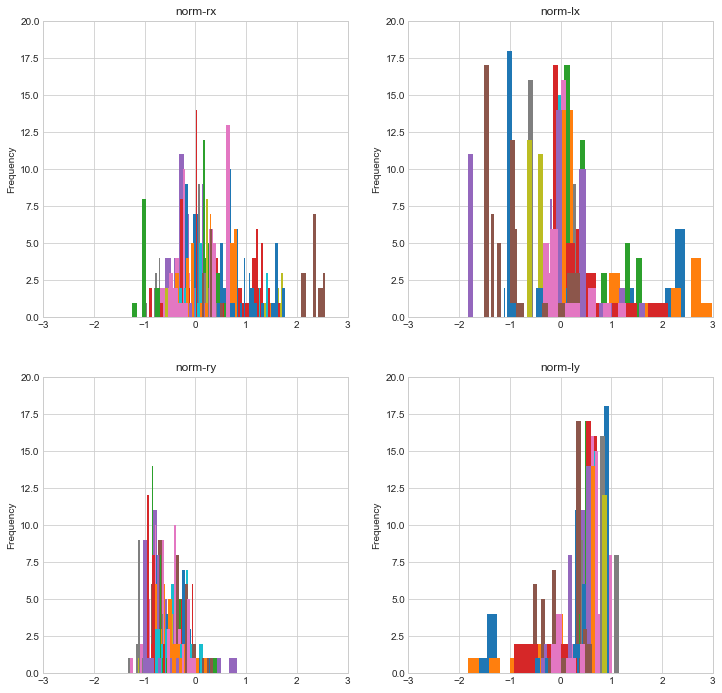

In [22]:
test_word='MARY'
fig=utils.make_histogram(samples['norm'][test_word],normed=True)

We can see distinct clustering in the 0~1 range for norm-ly, and more diffuse clustering in the -2~0 range for norm-ry.
Let's check the time series.

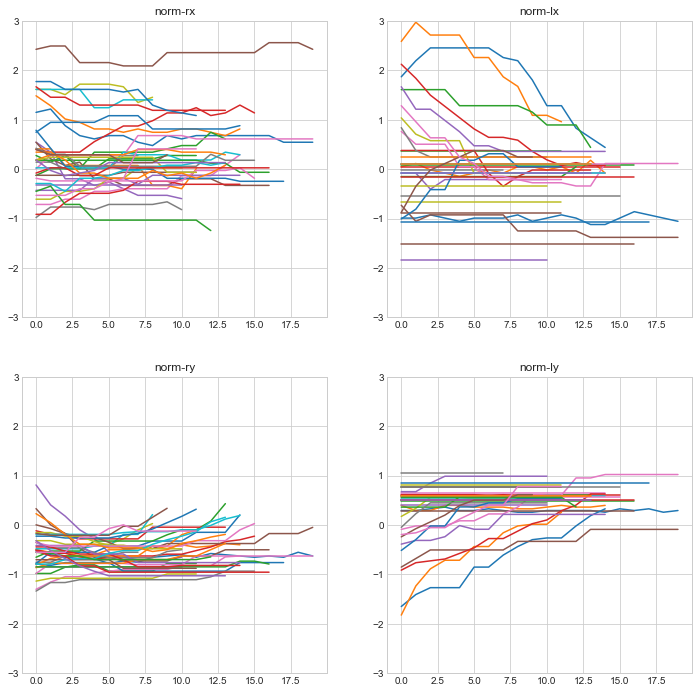

In [21]:
fig=utils.make_lines(samples['norm'][test_word])

We notice a lot of **noise for the left hand** signal, in the form of flat lines. Let's separate out those samples with flat signals.

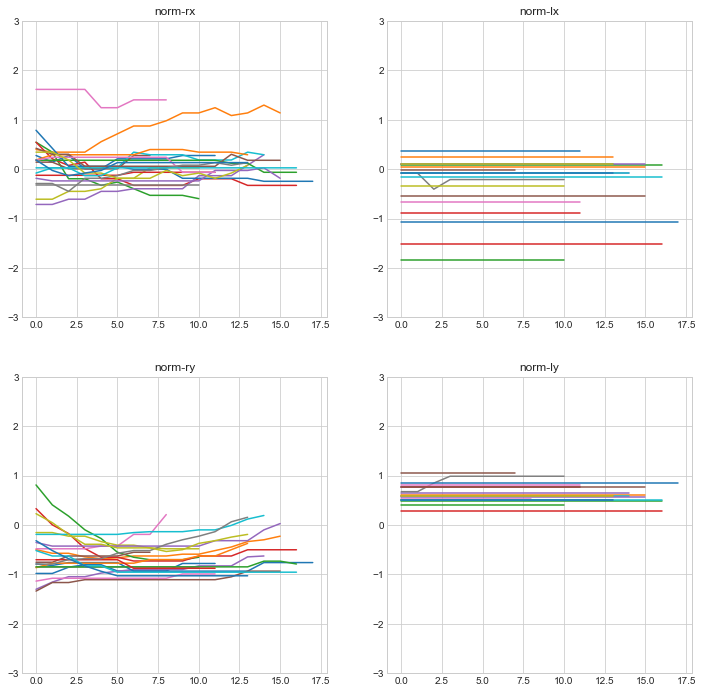

In [23]:
fig=utils.make_lines(handedness[test_word][0])

Basically the samples contain **no information** for the left hand. Now for the double-handed case.

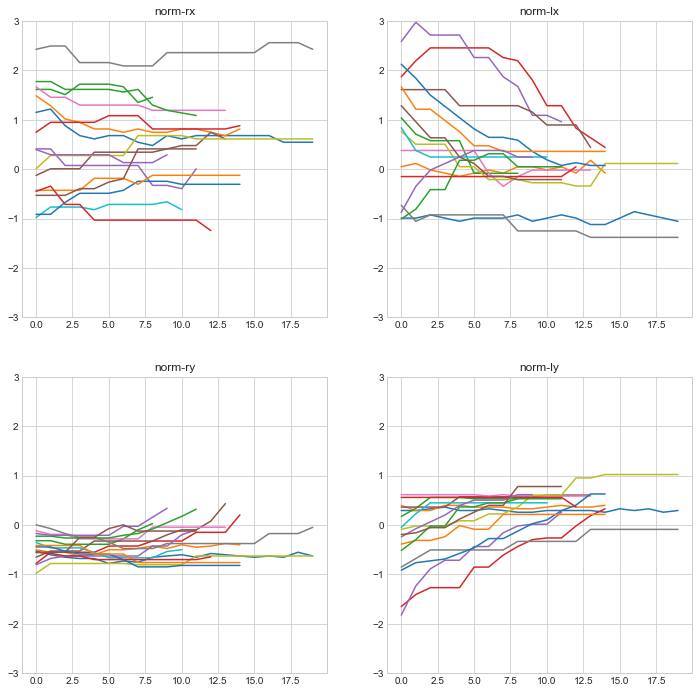

In [24]:
fig=utils.make_lines(handedness[test_word][1])

It's hard to reconcile these two distinct cases as being the same distribution. 

Thad Starner said it: ***I always like to check my assumptions, because they are often wrong.***

A simple and often neglected yet very powerful principle!

The possibility of some words having both single and double-handed versions was briefly mentioned in class but no recommendations were given, so I will list up my new assumptions. 

**Assumption:** *If the entire sample set of a word w contains signals for one hand only ==> word w is strictly a one-hand gesture.* $∀s∈S_{w} :single(s)⇒single(w)$

**Assumption:** *If the sample set of  word w contains some samples with signals for both hands and some samples with signals on one hand only ==> word W has both single- and double-handed versions.*
$∃s_{1},s_{2}∈S_{w} :single(s_{1}),double(s_{2})⇒both(w)$

**Assumption:** *Excluding such ambigious samples having multiple definitions would help make the excercise of comparing features and criteria more meaningful.*

==> I will use the below words for testing

In [2]:
test_words=words_info[(words_info.single==0) & (words_info['min']>4)].sort_values(by='count',ascending=False).head(4).index.tolist()
words_info[(words_info.single==0) & (words_info['min']>4)].sort_values(by='count',ascending=False).head(4)

,count,min,avg,max,range,spread,single,double
word,,,,,,,,
CAR,16,7,9.25,17,10,1.08,0,16
BUY,16,5,6.75,10,5,0.74,0,16
ARRIVE,15,5,10.20,17,12,1.18,0,15
HOUSE,10,9,14.00,16,7,0.50,0,10


Let's check the distributions for the highest-frequency word and **how they align across samples.**

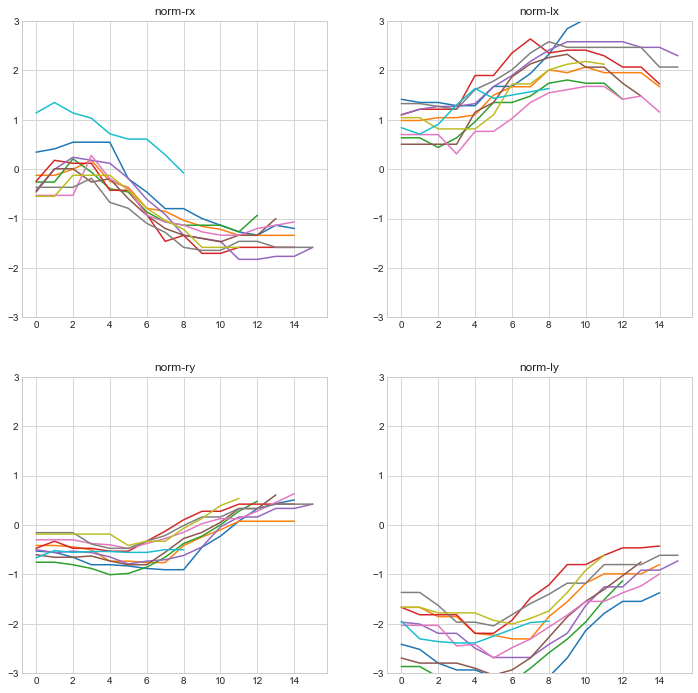

In [5]:
fig=utils.make_lines(samples['norm'][test_words[3]])

With the proposed selection criteria we seem to get suitable test words. We can even get a rough idea of the type of gesture from plotting on a x-y grid, colouring more recent samples **darker** to indicate movement. (Omitted for space reasons)

In [125]:
#for sample in samples['norm'][test_words[3][]]:
#    fig=utils.make_scatter(sample)

##### Custom features

**Assumption:** *Out of the four standard features 'norm' seems stricly better than 'grnd'. *

**Assumption:** *Depending on the gesture, either cartesian or polar coordinate could be preferrable. *
    
**Assumption:** *However, rather than mixing both cartesian and polar features, focusing on one seems to be the simplest and most tractable approach, less vulnerable to overfitting.*

==> I will focus on cartesian coordinates for my custom features. 

I like the idea of using delta, and noticed a **minor flaw** in the original definition.

Consider the following snippet of the delta-lx feature:

In [6]:
asl.df[['grnd-lx','delta-lx']].iloc[90:110].T

video        98                                                          \
frame        90     91     92     93     94     95     96     97     98   
grnd-lx  -10.00 -10.00 -10.00 -10.00 -10.00 -10.00 -10.00 -10.00 -10.00   
delta-lx   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

video        99                                                          \
frame        0      1      2      3      4      5      6      7      8    
grnd-lx  -17.00 -17.00 -17.00 -17.00 -17.00 -17.00 -17.00 -17.00 -17.00   
delta-lx  -7.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

video                   
frame        9      10  
grnd-lx  -17.00 -17.00  
delta-lx   0.00   0.00

We're seeing a spike in delta due to rolling into a new video. 

**Assumption:** *The videos should be considered individual samples and not carry history from a previous video*

==> Delta calculation must be reset at the start of a new video.

In [5]:
custom=['cdelta']
#dimensions
hand=['right','left']
side=['r','l']
cartesian = ['x','y']
polar = ['r','theta']

custom_features={k:[k+'-'+s+c for s in side for c in cartesian] for k in custom}
idx = pd.IndexSlice
for f in custom_features['cdelta']:
    ref='norm'+f[-3:]
    asl.df[f]=asl.df[ref].diff().fillna(0)
    #this resets the features where frame=0
    asl.df.set_value(asl.df.loc[idx[:,[0]], :].index,f,0)

#for k,v in custom_features.items():
#    features[k]=v
    #training[k]=asl.build_training(v)

#custom_samples=dict()
#for f in custom_features:
#    custom_samples[f]={k:utils.get_word(training,custom_features,f,k) for k in test_words}

C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [8]:
asl.df[['grnd-lx','norm-lx','delta-lx','cdelta-lx']].iloc[90:110].T

video         98                                                          \
frame         90     91     92     93     94     95     96     97     98   
grnd-lx   -10.00 -10.00 -10.00 -10.00 -10.00 -10.00 -10.00 -10.00 -10.00   
norm-lx    -0.89  -0.89  -0.89  -0.89  -0.89  -0.89  -0.89  -0.89  -0.89   
delta-lx    0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
cdelta-lx   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

video         99                                                          \
frame         0      1      2      3      4      5      6      7      8    
grnd-lx   -17.00 -17.00 -17.00 -17.00 -17.00 -17.00 -17.00 -17.00 -17.00   
norm-lx    -1.18  -1.18  -1.18  -1.18  -1.18  -1.18  -1.18  -1.18  -1.18   
delta-lx   -7.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
cdelta-lx   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

video                    
frame         9      10  
grnd-lx   -17.00 -17.00  
norm-lx    -1.18  -1.18  
delta-lx    0.00   0.00  
cdelta-lx   0.00   0.00

Starting frames now seem adjusted as expected.

In [126]:
#fig=utils.make_histogram(custom_samples['cdelta'][test_words[3]])

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** I decided on delta of normalized cartesian coordinates. As discussed, **normalizing** the data seems to help against **inter-person varations.** Using the **delta** rather than position also seems to better filter out the movement, although some care is needed to avoid effects spilling over from the last frame in previous video into the first frame of a new video. 

At this point I want to keep the number of features constant at four. Adding more features may achieve a **higher likelihood score simply due to overfitting**, which would complicate the comparison and distract from the analysis. 

*Start with the stupid stuff and add intelligence later.* 

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [33]:
import unittest
import numpy as np

features_ground=features['grnd']
features_norm=features['norm']
features_polar=features['polar']
features_delta=features['delta']

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.013s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word

In [186]:
import warnings
from hmmlearn.hmm import GaussianHMM
from importlib import reload

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

def fit_model(training,features_name,word,num_states,verbose=False):
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    X,lengths=training[features_name].get_word_Xlengths(word)
    m = GaussianHMM(n_components=num_states, n_iter=1000,verbose=verbose).fit(X, lengths)
   # logL = m.score(X, lengths)
    return m

def fit_trellis(training,features_name,word,num_states,verbose=False):
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    X,lengths=training[features_name].get_word_Xlengths(word)
    m = GaussianHMM(n_components=num_states,covariance_type='diag',init_params='cmt',params='cmts', n_iter=1000,verbose=verbose).fit(X, lengths)
    startprob_=np.zeros(num_states)
    startprob_[0]=1.0
    m.startprob_=startprob_
    # logL = m.score(X, lengths)
    return m

def score_model(model,training,word):
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    X, lengths = training.get_word_Xlengths(word)
    return model.score(X,lengths)

def likelihood_barchart(comparison):
    fig=plt.Figure()
    comparison.plot(kind='barh',alpha=0.5)
    plt.xlabel('logL')
    plt.title('log likelihood by feature ({})'.format(comparison.columns[0]))
    return fig

First I will train the models on a testword, with three states, and compare the results.

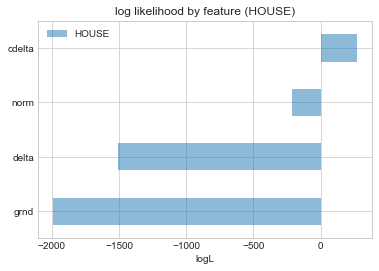

In [5]:
word=test_words[3]
n_states=3

models={k:fit_model(training,k,word,n_states,verbose=False) for k in ['grnd','norm','delta','cdelta']}
logL={k:score_model(v,training[k],word) for k,v in models.items()}
comparison=pd.DataFrame.from_dict(logL,orient='index').rename(columns={0:word}).sort_values(by=word,ascending=True)
fig=likelihood_barchart(comparison)

**Custom Delta** in the lead so far. But let's check under the hood to see the transition matricies.

##### Visualize the hidden states

In [103]:
np.set_printoptions(precision=2,suppress=True)
for k,v in models.items():
    print(k)
    print(v.transmat_*100)
#assert sum(sum(model.transmat_))==3.0

norm
[[ 85.14   0.    14.86]
 [  0.   100.     0.  ]
 [  0.    29.06  70.94]]
delta
[[73.43  6.94 19.63]
 [19.29 80.71  0.  ]
 [ 0.   21.88 78.11]]
grnd
[[100.     0.     0.  ]
 [ 11.51  86.17   2.32]
 [ 12.05   0.    87.95]]
cdelta
[[76.95  0.03 23.02]
 [18.89 74.32  6.8 ]
 [ 0.   19.51 80.49]]


In [127]:
#reload(utils)
#dott=utils.dot_hmm(models['cdelta'].transmat_)
#print(dott)

The equivalent graph for *cdelta* is shown below.

![text](cdelta.PNG)

Pretty similar to what we've seen in class. 

For the other models however, it looks like *grnd* has zero transition probability out of $S_{0}$, while *norm* has a zero transitions out of $S_{1}$?

**Assumption :** *We are working with the same left-to-right trellis flow as described in class*

==> In this particular case, 'grnd' would never leave the initial state, thus would not be able to make use of the trained model states.

I will now generate 100 samples from each model, starting in $S_{0}$ and plot the result for better intuition.

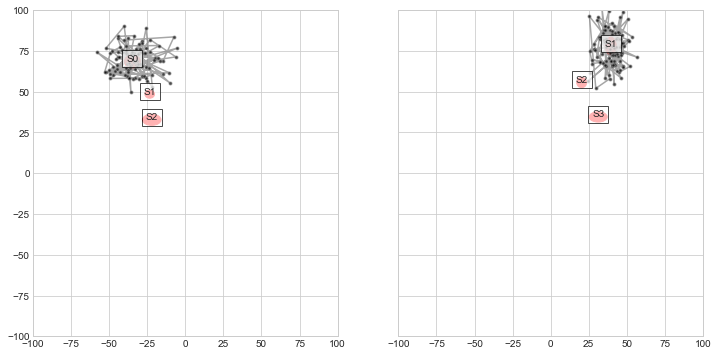

In [22]:
fig=utils.plot_states(models['grnd'],lim=100)

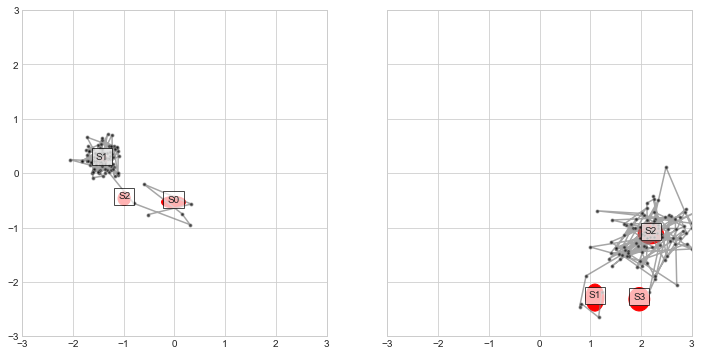

In [104]:
fig=utils.plot_states(models['norm'],lim=3)

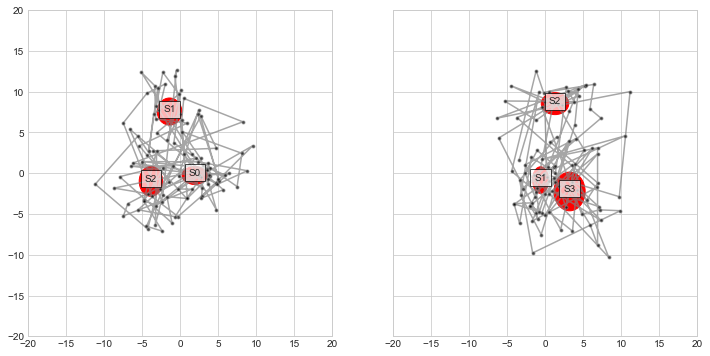

In [24]:
fig=utils.plot_states(models['delta'],lim=20)

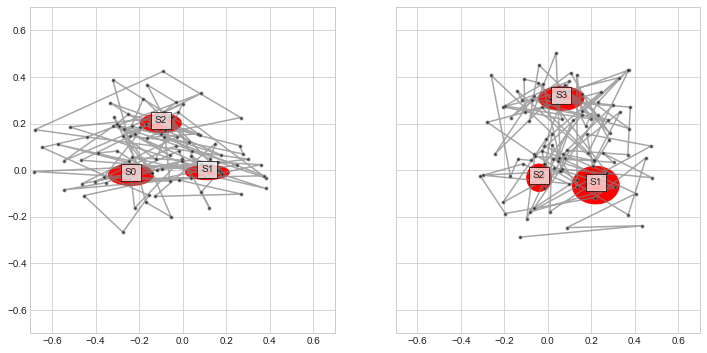

In [25]:
fig=utils.plot_states(models['cdelta'],lim=.7)

The plots illustrate how *grnd* nevel leaves the initial state $S_{0}$, while *norm* tends to get stuck in $S_{1}$ 

Next I will fit the custom model for number of states from 2,15 and plot the resulting logL

In [37]:
vs_states={k:fit_model(training,'cdelta',test_words[1],k,verbose=False) for k in range(2,16)}

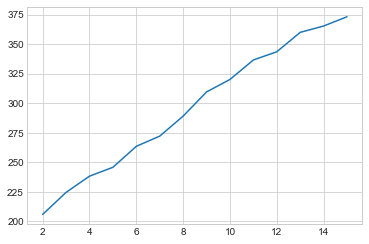

In [38]:
vs_logL={k:score_model(v,training['cdelta'],test_words[1]) for k,v in vs_states.items()}
plt.plot([k for k,v in vs_logL.items()],[v for k,v in vs_logL.items()])

Unsurprisingly, the logL increases with increasing number of states. But is the model getting more accurate? What about the transition probabilities?

In [46]:
np.set_printoptions(precision=2,suppress=True)
vs_states[3].transmat_

array([[0.7 , 0.  , 0.3 ],
       [0.06, 0.94, 0.  ],
       [0.  , 0.66, 0.34]])

In [40]:
np.set_printoptions(precision=2,suppress=True)
vs_states[5].transmat_

array([[0.09, 0.  , 0.91, 0.  , 0.  ],
       [0.16, 0.26, 0.42, 0.16, 0.  ],
       [0.27, 0.06, 0.01, 0.  , 0.66],
       [0.  , 0.48, 0.  , 0.51, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  ]])

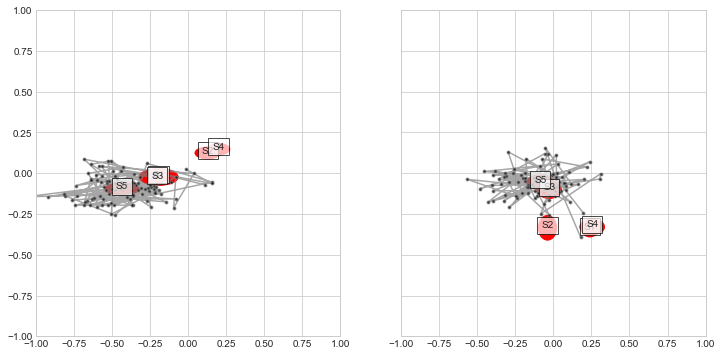

In [39]:
fig=utils.plot_states(vs_states[5],lim=1)

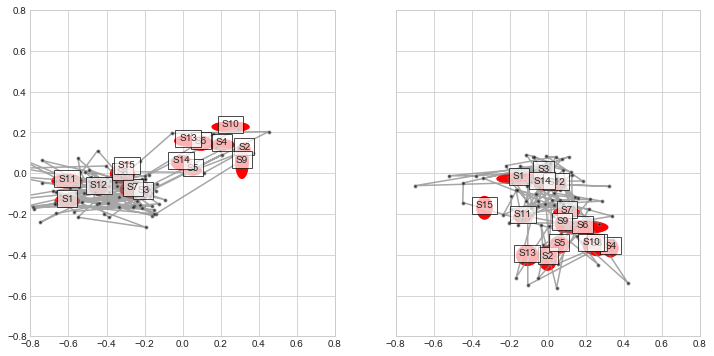

In [45]:
fig=utils.plot_states(vs_states[15],lim=0.8)

As long as the added states have non-zero transition probabilities, presumably something is gained. OTOH, some of the states are rarely getting used so it would seem that the left-to-right trellis doen't scale with the number of states in a consistent manner.

In [20]:
import math
%matplotlib inline
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        xmin,xmax=-3,3
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()

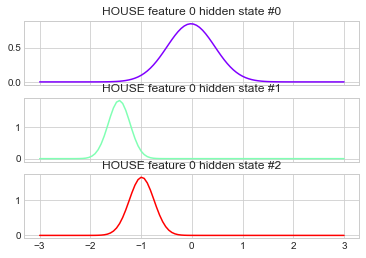

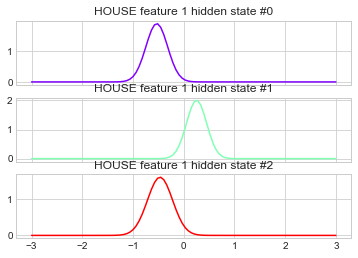

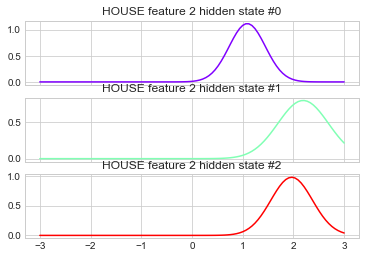

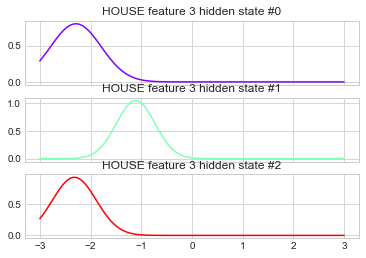

In [212]:
visualize(test_words[3], models['norm'])

<a id='part2_submission'></a>
### Model Selection Implementation Submission

Start by loading the training data for my custom feature.

In [10]:
#t=training['cdelta']
t = asl.build_training(custom_features.values())
sequences = t.get_all_sequences()
Xlengths = t.get_all_Xlengths()

words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']

**Cross-Validation**

Here we separate training and testing sequences (out-of-sample testing) to avoid overfitting.

In [214]:
from my_model_selectors import SelectorCV
verbose=False

CV=dict()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word,verbose=verbose, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        CV[word]=model
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.03829109999060165 seconds
Training complete for BOOK with 4 states with time 7.935182100001839 seconds
Training complete for VEGETABLE with 2 states with time 3.7846313000045484 seconds
Training complete for FUTURE with 3 states with time 6.505449399992358 seconds
Training complete for JOHN with 13 states with time 125.96407989998988 seconds


**Bayesian Information Criterion (BIC)**

Penalizes **complexity**. Selected based on *minimizing*

$$BIC = k \log ( n )  -2 \log (\hat L) $$

where *k* = features, *n* = samples, $\hat L$ = the maximized Likelihood

In [82]:
from my_model_selectors import SelectorBIC 
verbose=False

BIC=dict()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word,verbose=verbose, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        BIC[word]=model
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 1.062698099995032 seconds
Training complete for BOOK with 3 states with time 3.9328874999919208 seconds
Training complete for VEGETABLE with 2 states with time 4.863086800003657 seconds
Training complete for FUTURE with 5 states with time 3.345292800004245 seconds
Training complete for JOHN with 5 states with time 41.59263289999217 seconds


**Discriminative Information Criterion (DIC)**

Applies a penalty if the model does not sufficiently **outperform** the other candidates.

Selected based on *maximizing*

$$DIC = \log (\hat L_i) - \sum_{j=i+1}^N \frac{L_j}{N-1} $$

where *i* = indicates the current model we are evaluating.

In [96]:
from my_model_selectors import SelectorDIC
verbose=False

DIC=dict()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word,verbose=verbose, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        DIC[word]=model
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 216.82203209999716 seconds
Training complete for BOOK with 14 states with time 0.006861699992441572 seconds
Training complete for VEGETABLE with 2 states with time 0.0008577000116929412 seconds
Training complete for FUTURE with 5 states with time 0.004154199996264651 seconds
Training complete for JOHN with 14 states with time 0.0009136000007856637 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** 
According to **Occam's Razor**, we should pick the simplest model that gives the best fit. While **BIC** penalizes complexity, **DIC** prioritizes the fit dimension by applying a penalty if the model does not sufficiently outperform the other candidates. Generally, this should be more sensitive to **overfitting**, so perhaps using both in tandem is a sound approach.

**Cross-Validation** is more of a general principle in Machine Learning. It is always preferable to use separate samples for training and testing/prediction. However, this relies on having enough data to make sufficient sample sizes for both training and testing. In our case this is not really the case, as many words have too few samples to break up into separate sets.   

In terms of **implementation** performance, SelectorDIC is slow since it needs to fit $n_{words}$ models to score one word, which would be $O(n^2)$ for each iteration of $n_{states}$. 

Fortunately this could be brought down to $O(n)$ by precalculating a $n_{words}*(n_{max_states}-n_{max_states})$ matrix stored as a class attribute and shared by all SelectorDIC instances. This turns the SelectorDIC time complexity into an intial overhead, after which it scales better than SelectorBIC as the combinations of features and state sizes increase.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [42]:
from asl_test_model_selectors import TestSelectors
import unittest
from warnings import filterwarnings
filterwarnings('ignore')
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 42.850s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set

In [106]:
def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [44]:
test_set = asl.build_test(features)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission

I ran the tests in a batch and saved the results in a report DB.

In [62]:
from pickleshare import PickleShareDB
db = PickleShareDB('reports')

In [63]:
feature_names=['norm','delta','polar','cdelta']
report={k:db.get(k) for k in feature_names}
summary=dict()
wer=dict()
for k,v in report.items():
    summary[k],top10[k]=utils.make_summary(v)
    wer[k]=1-summary[k][selector_names].sum()/float(len(v))   

In [105]:
import utils
from importlib import reload
reload(utils)
wer_comparison=utils.compare_wer(wer)


C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


##### WER comparison

In [106]:
wer_comparison

,cdelta,delta,norm,polar
index,,,,
SelectorCV,0.56,0.57,0.66,0.65
SelectorBIC,0.54,0.59,0.63,0.55
SelectorDIC,0.56,0.60,0.60,0.52
harm-mean,0.55,0.59,0.63,0.57


**Selector Models**

We can see the largest spread in WER between features for **SelectorCV**. This seems intuitive, as this selector does not adjust for neither complexity nor outperformance. **SelectorBIC** and **SelectorDIC** have roughly similar results for WER.

**Features**

Since WER is a ratio, in order to compare WER by features I use the **harmonic mean**. My custom feature **cdelta** beats the other features, but the difference is not that big. 

**Word differences**

10 words account for over half of the samples in this set (96 of 178 samples). This will have an impact on the resulting statistics.

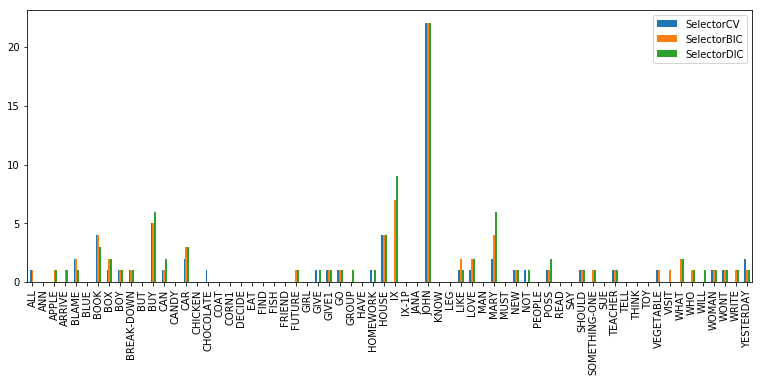

In [135]:
feature_names=['norm','delta','polar','cdelta']
hits={k:summary[k][selector_names] for k in feature_names}
hits['polar'].index.rename('',inplace=True)
hits['polar'].plot.bar(figsize=(13,5))

The chart above shows the hits for the polar features.
The three selectors are all very good at telling the highest-frequency word **JOHN**. However, for the next most common words **MARY, IX** we can see a spread for **DIC** vs **CV**, which explains the spread in overall WER we saw earlier.

It seems that we have to take this uneeven word distribution into account. Let's take it one more step and check the  
[Table of confusion](https://en.wikipedia.org/wiki/Confusion_matrix) for the three most frequent words.

According to the article:

**Accuracy** is not a reliable metric for the real performance of a classifier, because it will yield misleading results if the data set is unbalanced (that is, when the numbers of observations in different classes vary greatly). For example, if there were 95 cats and only 5 dogs in the data set, a particular classifier might classify all the observations as cats. The overall accuracy would be 95%, but in more detail the classifier would have a 100% recognition rate (sensitivity) for the cat class but a 0% recognition rate for the dog class. 

**F1 score** is even more unreliable in such cases, and here would yield over 97.4%, whereas **Informedness** removes such bias and yields 0 as the probability of an informed decision for any form of guessing (here always guessing cat).

In [154]:
def make_tc(report,true_word='JOHN',feature_name='norm'):
    performance=dict()
    performance['TP']=(report[report.word==true_word][selector_names]==true_word).sum()
    performance['FP']=(report[report.word!=true_word][selector_names]==true_word).sum()
    performance['TN']=(report[report.word!=true_word][selector_names]!=true_word).sum()
    performance['FN']=(report[report.word==true_word][selector_names]!=true_word).sum()
    tc=pd.DataFrame.from_records(performance)
    tc['rTP']=tc.TP/(tc.TP+tc.FN) #AKA sensitivity
    tc['rTN']=tc.TN/(tc.FP+tc.TN) #AKA specificity
    tc['PPV']=tc.TP/(tc.TP+tc.FP) #AKA precision
    tc['NPV']=tc.TN/(tc.TN+tc.FN) 
    tc['LR+']=tc.rTP/(1-tc.rTN) 
    tc['LR-']=(1-tc.rTP)/tc.rTN 
    tc['ACC']=(tc.TP+tc.TN)/(tc.TP+tc.FN+tc.TN+tc.FN) 
    tc['F1']=2*(tc.TP)/(2*tc.TP+tc.FP+tc.FN) 
    tc['informed']=tc.rTP+tc.rTN-1
    tc['word']=true_word
    tc.index.rename('model',inplace=True)
    return tc.reset_index().set_index(['word','model'])

In [146]:
#top3={k:top10['polar'] for k in top10['polar'].head(3).index.tolist()}
top10['polar']

,SelectorCV,SelectorBIC,SelectorDIC,N,avg len
word,,,,,
JOHN,22,22,22,30,11.97
IX,0,7,9,18,10.06
MARY,2,4,6,9,12.00
BUY,5,5,6,9,6.22
BOOK,4,4,3,6,9.00
GIVE,1,0,1,6,15.17
CAN,1,1,2,5,8.40
LIKE,1,2,1,5,5.40
HOUSE,4,4,4,4,14.00


In [155]:
table_of_confusion={k:make_tc(report['polar'],k,'polar') for k in top10['polar'].head(3).index.tolist()}

In [156]:
table_of_confusion['JOHN']#.style.apply(highlight_max)

FN  FP   TN  TP  rTP  rTN  PPV  NPV   LR+  LR-  ACC   F1  \
word model                                                                   
JOHN SelectorCV    8   4  144  22 0.73 0.97 0.85 0.95 27.13 0.27 0.91 0.79   
     SelectorBIC   8  10  138  22 0.73 0.93 0.69 0.95 10.85 0.29 0.91 0.71   
     SelectorDIC   8   9  139  22 0.73 0.94 0.71 0.95 12.06 0.28 0.91 0.72   

                  informed  
word model                  
JOHN SelectorCV       0.71  
     SelectorBIC      0.67  
     SelectorDIC      0.67

For **JOHN**, all models score high across the measures. This explains why the overall WER are quite similar.

In [149]:
table_of_confusion['IX']

FN  FP   TN  TP  rTP  rTN  PPV  NPV   LR+  LR-  ACC   F1  \
word model                                                                   
IX   SelectorCV   18   1  159   0 0.00 0.99 0.00 0.90  0.00 1.01 0.82 0.00   
     SelectorBIC  11   5  155   7 0.39 0.97 0.58 0.93 12.44 0.63 0.88 0.47   
     SelectorDIC   9  12  148   9 0.50 0.93 0.43 0.94  6.67 0.54 0.90 0.46   

                  informedness  
word model                      
IX   SelectorCV          -0.01  
     SelectorBIC          0.36  
     SelectorDIC          0.43

For the second most common **IX**, **SelectorCV** misses all 18 samples! This shows up as a informedness score of zero.

In [150]:
table_of_confusion['MARY']

FN  FP   TN  TP  rTP  rTN  PPV  NPV  LR+  LR-  ACC   F1  \
word model                                                                  
MARY SelectorCV    7  11  158   2 0.22 0.93 0.15 0.96 3.41 0.83 0.92 0.18   
     SelectorBIC   5   9  160   4 0.44 0.95 0.31 0.97 8.35 0.59 0.94 0.36   
     SelectorDIC   3  13  156   6 0.67 0.92 0.32 0.98 8.67 0.36 0.96 0.43   

                  informedness  
word model                      
MARY SelectorCV           0.16  
     SelectorBIC          0.39  
     SelectorDIC          0.59

For **MARY**, **SelectorCV** misses cathces 2 of 9 samples, which is a Positive Predictive Value of 0.15. It is better at avoiding False Positives, with a NegativePredictive Value of 0.96.

In [157]:
wer_comparison

,cdelta,delta,norm,polar
index,,,,
SelectorCV,0.56,0.57,0.66,0.65
SelectorBIC,0.54,0.59,0.63,0.55
SelectorDIC,0.56,0.60,0.60,0.52
harm-mean,0.55,0.59,0.63,0.57


**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:** 

I found my custom feature cdelta to outperform the other features on a **harmonic mean** basis. The other cartesian features were similar but consistently worse.

The **polar** features gave the most interesting and varied results, so I focused the analysis on these. For **DIC** it actually outperformed my **custom**, however the WER was considerably higher for **CV** and the harmonic mean also higher.

**DIC** is more prone to selecting overfitted models, which could be the reason behind this spread in performance for **polar**.

In addition, the three selectors are all very good at telling the highest-frequency word **JOHN**. However, for the next most common words MARY, IX we can see a spread for DIC vs CV, which seems to explains the spread in overall WER we saw earlier.

Since we are working with a uneven distribution of words, I decided to add additional statistics since WER alone might not tell the whole story. 
In particular, the poor predictive power of **CV** for **IX** using **polar** features came to zero **informedness**, and this word affected the overall WER for **polar**.

**What additional information might we use to improve our WER?**

One thing we could see was the impact of the **high prior probabilities** for a few words like **JOHN**. In the below example the model repeatedly gives false positives for **JOHN**, simply due to it having a high frequency in the sample. In this case we should expect to improve the results by adding information about the sequence of words (However I will skip this optional part due to time constraints). 
    
    90: JOHN *JOHN *JOHN *GIVE WOMAN *MARY                            JOHN GIVE IX SOMETHING-ONE WOMAN BOOK

Another thing I explored was the **quality and consistency of the data**. There were many samples containing two versions, single and double-handed. This was mentioned in class but we were not given guidelines on how to deal with those. Some other words were split up in two version, perhaps the same could be done here.

Using the **labels for different speakers** might also be useful. While we do not have enough data to consider all different speak, classification based on gender should be possible.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [159]:
import unittest
warnings.filterwarnings('ignore')
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)